<a href="https://colab.research.google.com/github/KatieONell/pink-noise/blob/main/figures_and_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment and helper functions

In [ ]:
#@title Install/import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from sklearn.linear_model import LinearRegression
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import glob
from scipy.stats import chisquare
from scipy.stats import ttest_ind
import re
from scipy.spatial.distance import pdist, squareform
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams.update({'font.size': 22})
!pip install mantel
import mantel

In [ ]:
#@title Helper functions for Figure 3

def fix_nans(x,y):
  x = np.array(x)
  y = np.array(y)
  out_x = x[np.isfinite(x+y)]
  out_y = y[np.isfinite(x+y)]
  return((out_x, out_y))

def get_cmap(hex_color):
  r,g,b = (tuple(int(hex_color[i:i+2], 16)/255 for i in (1, 3, 5)))
  return LinearSegmentedColormap.from_list(
        "Custom", [(1-r, 1-g, 1-b), (1,1,1), (r,g,b)], N=101)

def stats_statement(r, p):
  base, exponent = "{p:.0e}".format(p=p).split('e')
  statement = "R = {r:.2f}\np = ${base} \cdot 10^{{{exponent}}}$".format(r=r, base=base, exponent=int(exponent))
  if p < 0.001:
    return statement+ ' (***)'
  elif p < 0.01:
    return statement+ ' (**)'
  elif p < 0.05:
    return statement+ ' (*)'
  else:
    return 'R = {r:.2f}\np = {p:.2f} (n.s.)'.format(r=r,p=p)

def get_heatmap_df(dataset, n):
  if dataset == 'candor':
    if n == 0:
      variables = [' ', 'How enjoyable', 'Overall affect','You like me', 'Desired convo\nlength', ' ']
      weights = [np.nan, 0.25, 0.25, 0.244, 0.15, np.nan]
    elif n == 1:
      variables = [' ', 'Our thoughts\nconverged', 'Developed joint\nperspective', 'Shared thoughts\nand feelings', 'We anticipated\neach other', ' ']
      weights = [np.nan, 0.302, 0.2999, 0.294, 0.257, np.nan]
    else:
      variables = ['', 'I am warm', 'Extraversion', ' ', 'AQ social\nskill deficit', 'Neuroticism']
      weights = [np.nan, 0.23, 0.156, np.nan, -0.113, -0.1767]
  elif dataset == 'interracial-friends':
    if n == 0:
      variables = [' ', 'Convo was\nmeaningful', 'Overall\nassessment', 'Appreciated\nconvo',  'Post-convo\nenergy', 'Post-convo\ngladness',]
      weights = [np.nan, 0.486, 0.45,0.443, 0.433, 0.421]

    elif n == 1:
      variables = ['', 'Post-convo trust\nin friend', 'Post-convo connection\nw/ friend', 'Post-convo closeness\nto friend', '', '']
      weights = [np.nan, 0.5996, 0.5847, 0.546, np.nan, np.nan]

    else:
      variables = ['','Political\nideology', 'Social\nideology', 'Ideological\nbias','','']
      weights = weights = [np.nan, 0.642, 0.621, -0.44996, np.nan, np.nan]

  df = pd.DataFrame({'variable': variables, ' ': weights})
  df.index = df['variable']
  df = df[[' ']]
  return df


In [ ]:
#@title Fetch data from OSF
!wget https://files.osf.io/v1/resources/7ju2s/providers/osfstorage/67e3417e4fc71658de6b468d/?zip= -O candor-and-interracial-friends.zip
!unzip candor-and-interracial-friends.zip
!wget https://osf.io/download/67e4283e709404ec62e2b8e8/ -O blink-date-pnrs.csv
!wget https://osf.io/download/67e428fde933f5ebecceafbc/ -O kings-and-kweens-pnrs.csv
!mkdir podcast-pnrs
!wget https://files.osf.io/v1/resources/7ju2s/providers/osfstorage/67e37fdc720a3932978e58ee/?zip= -O podcast-pnrs.zip
!unzip podcast-pnrs.zip -d podcast-pnrs
!wget https://osf.io/download/67e342814fc71658de6b46be/ -O claude-conversation-pnrs.csv
!wget https://osf.io/download/67e42c3f59f4e39eedbca4ff/ -O original-prolific-data.csv

In [ ]:
!wget https://osf.io/download/67e42c3f59f4e39eedbca4ff/ -O original-prolific-data.csv

In [ ]:
#@title Read in and organize data
#CANDOR and Interracial Friends
with open('candor-PCs.json') as fp:
  candorPCs = json.load(fp)
with open('interracial-friends-PCs.json') as fp:
  interracialPCs = json.load(fp)
candorCorrelations = pd.read_csv('candor-survey-correlations.csv')

#CANDOR controls
rows = []
for convo_id in candorPCs.keys():
  whole_convo_pnr = candorPCs[convo_id]['pnr']
  speakerA, speakerB = candorPCs[convo_id]['individual_values'].keys()
  individual_pnr_A = candorPCs[convo_id]['individual_values'][speakerA]['pnr']
  individual_enjoyment_A = candorPCs[convo_id]['individual_values'][speakerA]['survey_pca']['Enjoyment_PC1']
  individual_connection_A = candorPCs[convo_id]['individual_values'][speakerA]['survey_pca']['Connection_PC1']
  individual_pnr_B = candorPCs[convo_id]['individual_values'][speakerB]['pnr']
  individual_enjoyment_B = candorPCs[convo_id]['individual_values'][speakerB]['survey_pca']['Enjoyment_PC1']
  individual_connection_B = candorPCs[convo_id]['individual_values'][speakerB]['survey_pca']['Connection_PC1']
  rows.append([individual_enjoyment_A, individual_connection_A, whole_convo_pnr, individual_pnr_A, individual_pnr_B])
  rows.append([individual_enjoyment_B, individual_connection_B, whole_convo_pnr, individual_pnr_B, individual_pnr_A])
individualData = pd.DataFrame(rows, columns=['enjoyment', 'connection', 'whole_convo_pnr', 'speaker_pnr', 'partner_pnr'])
individualData.to_csv('individualData.csv')

rows = []
for convo_id in candorPCs.keys():
  enjoyment = candorPCs[convo_id]['survey_pca']['Enjoyment_PC1']
  connection = candorPCs[convo_id]['survey_pca']['Connection_PC1']
  pnr = candorPCs[convo_id]['pnr']
  similarity_slope = candorPCs[convo_id]['similarity_slope']
  average_similarity = candorPCs[convo_id]['average_similarity']
  similarity_variance = candorPCs[convo_id]['similarity_variance']
  rows.append([enjoyment, connection, pnr, similarity_slope, average_similarity, similarity_variance])
linearAlternatives = pd.DataFrame(rows, columns=['enjoyment', 'connection', 'pnr', 'similarity_slope', 'average_similarity', 'similarity_variance'])
linearAlternatives.to_csv('linearAlternatives.csv')

#Blink Date
blink = pd.read_csv('blink-date-pnrs.csv')
blink_date_matches = blink[blink['matched']=='yes']['pnr']
blink_date_misses = blink[blink['matched']=='no']['pnr']

#Kings and Kweens
kings = pd.read_csv('kings-and-kweens-pnrs.csv')
for r in range(len(kings)):
  if kings.iloc[r]['date_count'] == 4:
    if kings.iloc[r]['pnr_order'] in [2,3]:
      kings.loc[r,'pnr_order'] -= 1
kings_kweens_misses = kings[kings['winner']==0]['pnr_order']
kings_kweens_matches = kings[kings['winner']==1]['pnr_order']
kings.to_csv('kings-kweens.csv')

#Longitudinal Podcasts
dfList = []
for filename in glob.glob('podcast-pnrs/*.csv'):
  podcastDF = pd.read_csv(filename)
  podcastDF['Podcast'] = ' '.join(filename.split('/')[-1].split('.')[0][:-5].split('-')).title()
  podcastDF = podcastDF[podcastDF['episode'].notna()]
  dfList.append(podcastDF)
podcasts = pd.concat(dfList)
podcasts = podcasts[podcasts['exclusion'].isna()]
podcasts['Podcast'] = podcasts['Podcast'].replace({'Lets Go To Court': 'Let\'s Go To Court'})
podcasts['Podcast'] = podcasts['Podcast'].replace({'Best Friends Ruview': 'Best Friends RuView'})
podcasts['Podcast'] = podcasts['Podcast'].replace({'The Frdi Show': 'The FRDI Show'})
podcasts['Podcast'] = podcasts['Podcast'].replace({'A Town': 'A-Town FM'})
podcasts['Podcast'] = podcasts['Podcast'].replace({'Who Weekly': 'Who? Weekly'})
podcasts['Podcast'] = podcasts['Podcast'].replace({'Your Best Friends Bookshelf': 'Your Best Friend\'s Bookshelf'})
podcasts['Episode'] = podcasts['episode']
podcasts.to_csv('podcasts.csv')

#Claude Convos
claude = pd.read_csv('claude-conversation-pnrs.csv')
bad_convo_pnrs = claude[claude['condition']=='bad']['pnr']
good_convo_pnrs = claude[claude['condition']=='good']['pnr']

#Claude online ratings
prolific_data = pd.read_csv('original-prolific-data.csv')
participants = []
for i in range(len(prolific_data)):
  passed_attention = True
  row = prolific_data.iloc[i].dropna()
  participant = [np.nan]*6
  for c in row.index:
    if 'attention' in c:
      condition, convo_n, ac_n, ac_answer = re.findall('-check-([a-z]+?)-(\d+?)-(\d)_(\d)', c)[0]
      if ac_answer != '1':
        passed_attention = False
    elif 'enjoyment' in c:
      rating = float(re.findall('\d_(\d)', c)[0])
      if '.' not in c:
        enjoymentQ = 'enjoyment'
        participant[3] = rating
      elif '.1' in c:
        enjoymentQ = 'connection'
        participant[4] = rating
      else:
        enjoymentQ = 'understanding'
        participant[5] = rating

  participant[0] = condition
  participant[1] = str(int(convo_n))
  participant[2] = passed_attention
  participants.append(participant)

claude_ratings = pd.DataFrame(participants, columns = ['condition', 'convo_n', 'passed_attention', 'enjoyment', 'connection', 'understanding'])
claude_ratings = claude_ratings[claude_ratings['passed_attention']==True].reset_index(drop=True).dropna()
claude_ratings = claude_ratings.groupby(['condition', 'convo_n']).mean().reset_index()

# Figures

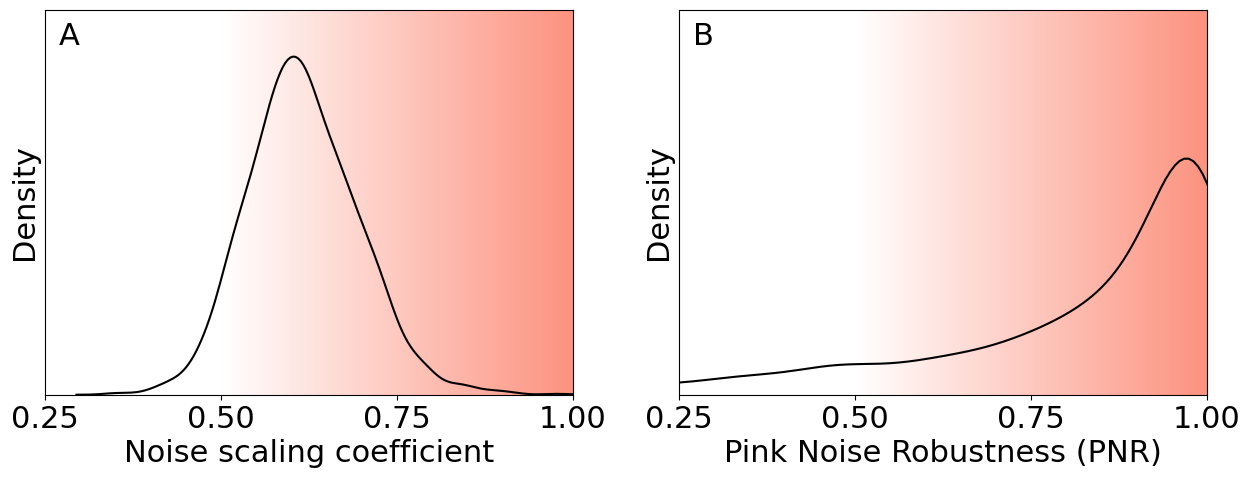

In [36]:
#@title Figure 2: Distribution of noise scaling coefficients and pink noise robustness scores for the CANDOR corpus

#Get Hursts and PNRs
candor_hursts = [candorPCs[key]['hurst'] for key in candorPCs.keys()]
candor_pnrs = [candorPCs[key]['pnr'] for key in candorPCs.keys()]

#Pink gradient background
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
colors = ["#FFFFFF", "#fc927f", "#FA5234"]
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=5000)

#Hurst subplot
ax1.bar(np.linspace(0.5, 1.5, 5000), [10]*5000, width=1/5000, color=[cm(x) for x in range(5000)])
sns.kdeplot(candor_hursts, color='k', ax=ax1)#, fill=True, alpha=0.05)
ax1.set_xlabel('Noise scaling coefficient')
ax1.set_xlim(0.25, 1.0)
ax1.set_xticks([0.25, 0.50,0.75,1.0])
ax1.set_yticks([])
ax1.set_ylim(0,6)
ax1.text(0.27, 5.45, 'A')

#PNR subplot
ax2.bar(np.linspace(0.5, 1.5, 5000), [10]*5000, width=1/5000, color=[cm(x) for x in range(5000)])
sns.kdeplot(candor_pnrs, color='k', ax=ax2)#, fill=True, alpha=0.05)
ax2.set_xlabel('Pink Noise Robustness (PNR)')
ax2.set_xlim(0.25, 1.0)
ax2.set_xticks([0.25, 0.50,0.75,1.0])
ax2.set_yticks([])
ax2.set_ylim(0,6)
ax2.text(0.27, 5.45, 'B');


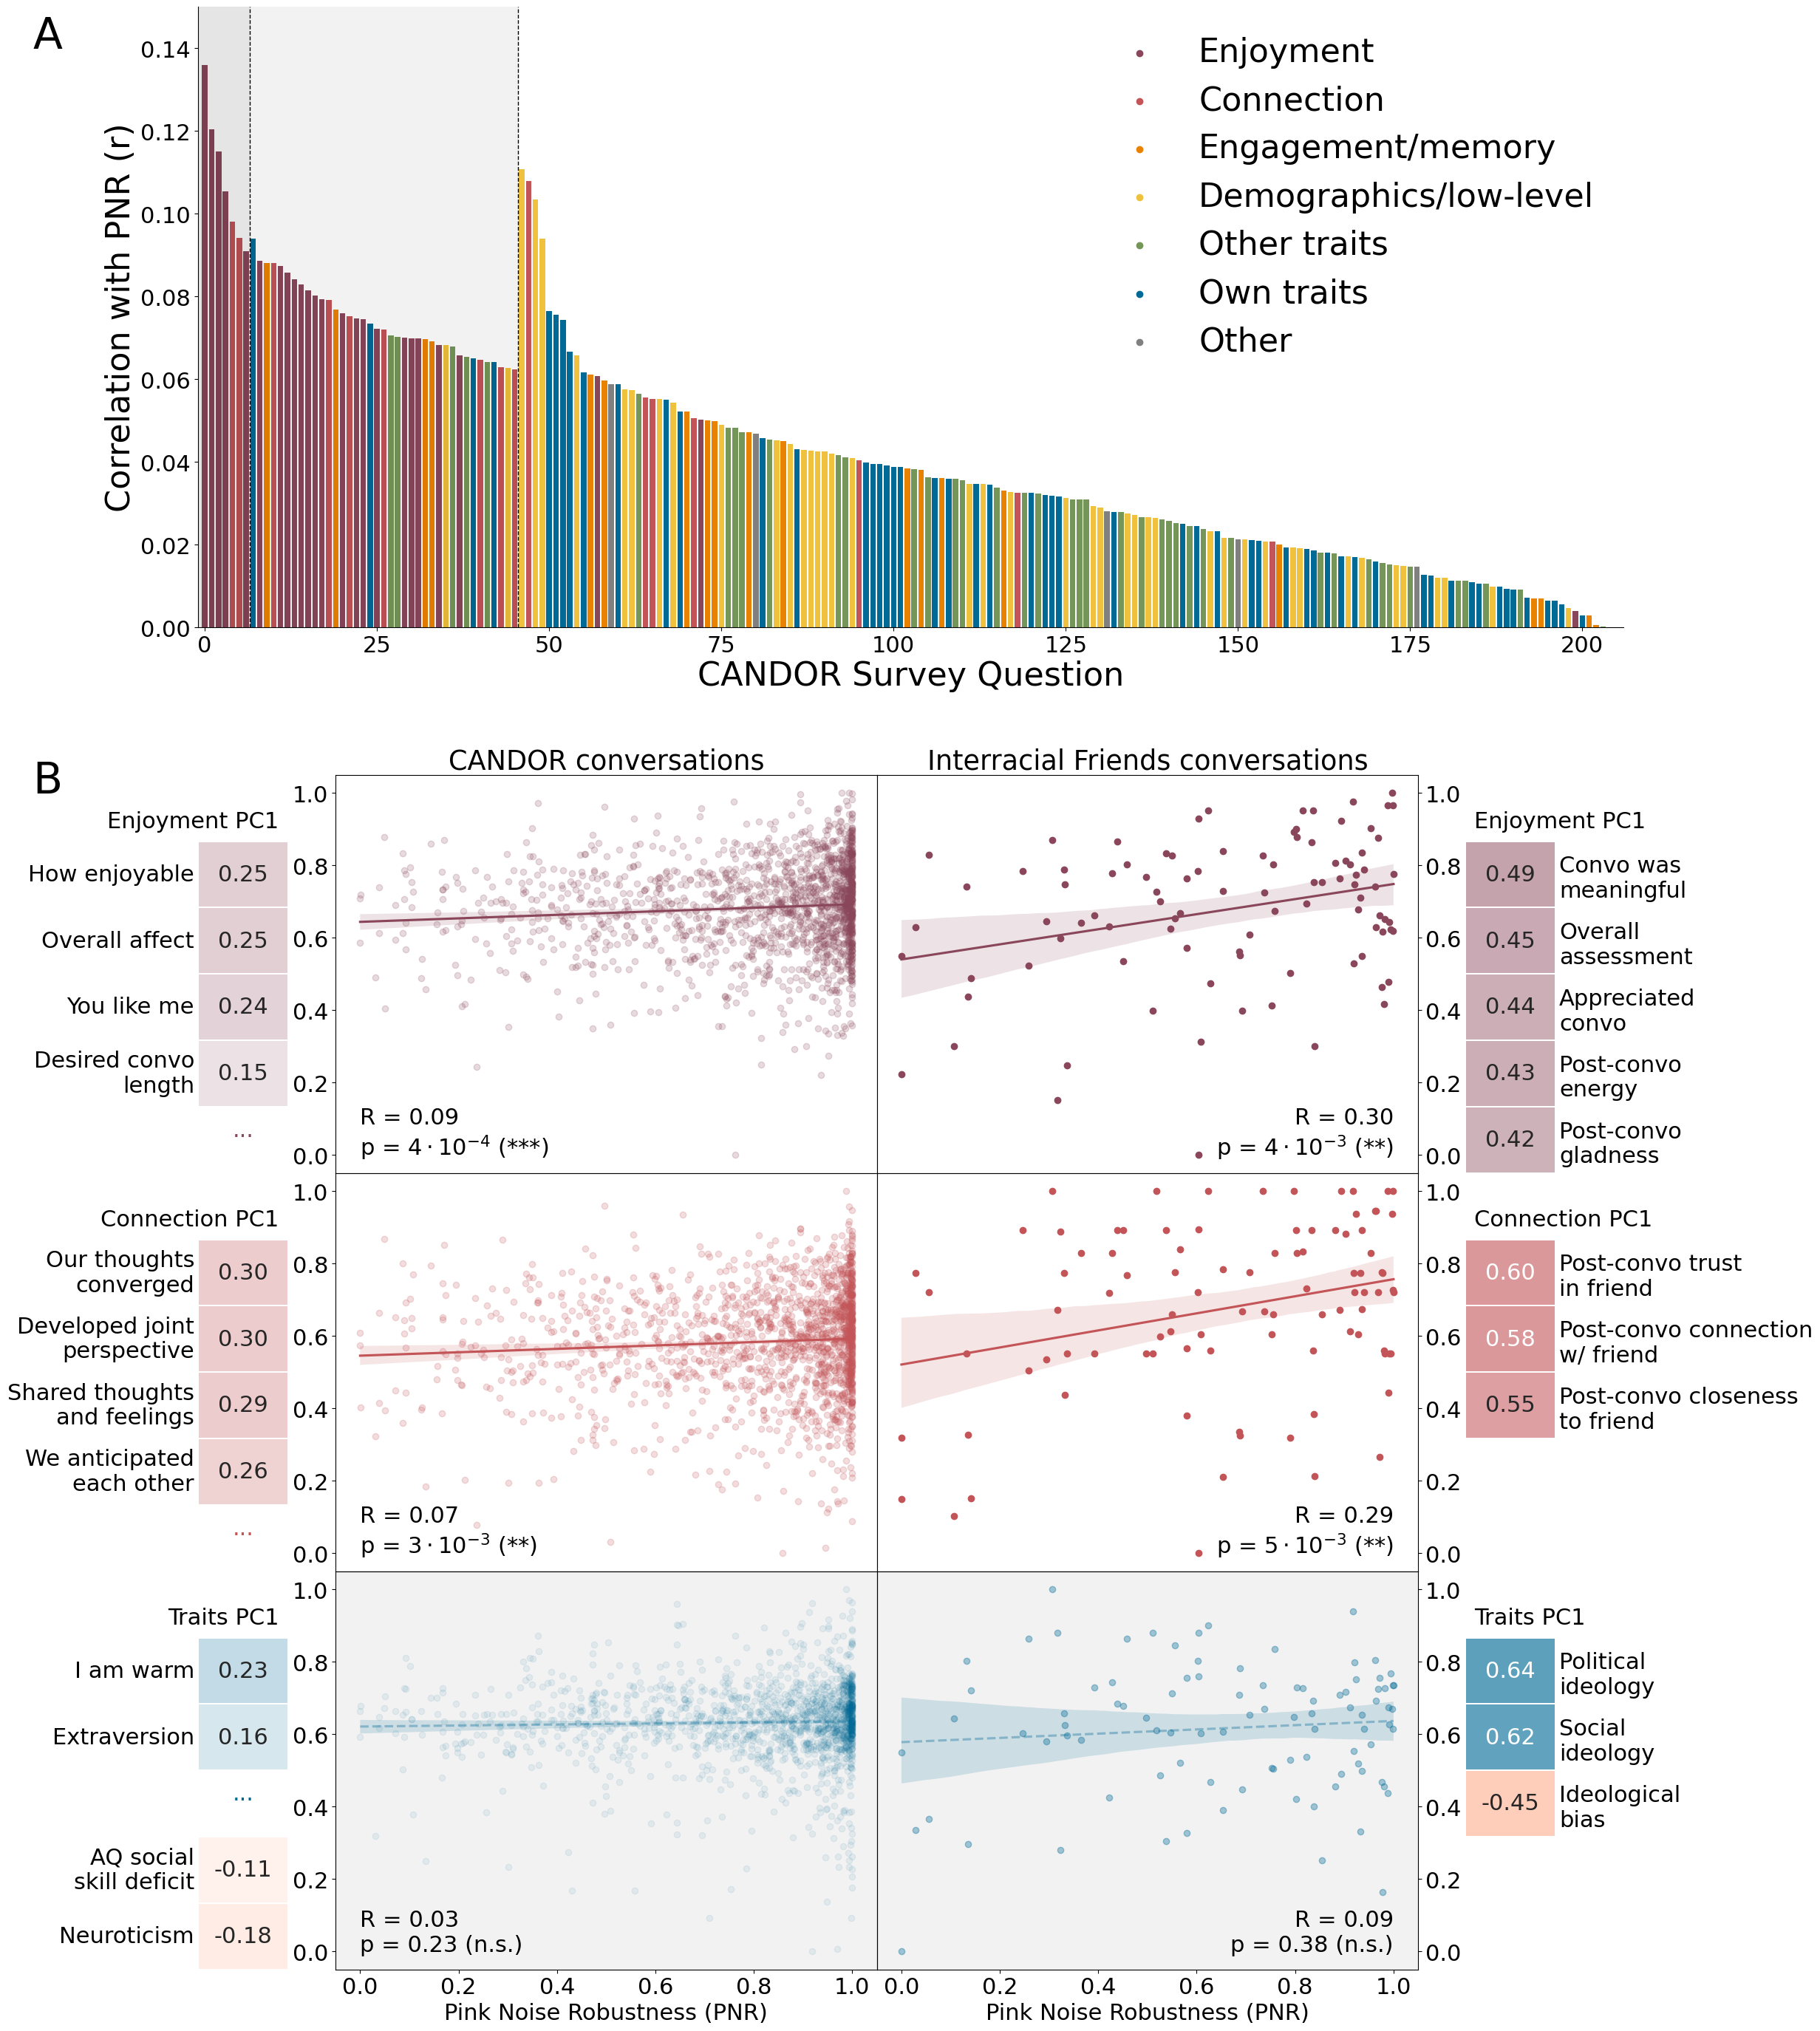

In [37]:
#@title Figure 3: Pink noise robustness predicts positive conversation outcomes in two corpora
#set color settings
colors = ["#8a475b", "#c35457", "#006a97"]
categories = ['Enjoyment_PC1', 'Connection_PC1', 'Own traits_PC1']
titles = ['Enjoyment PC1', 'Connection PC1', 'Traits PC1']
category2color = {'Enjoyment':"#8a475b",
 'Connection': "#c35457",
 'Engagement/memory': "#ea8201",
 'Demographics/low-level': "#efc13c",
 'Other traits': "#749658",
 'Own traits': "#006a97",
  'Other': "#808080"}

#SET UP FIGURE FRAME
fig = plt.figure(figsize=(10.5*1.75, 12*1.75))#, dpi=900)
gsTop = fig.add_gridspec(nrows=1, ncols=1, width_ratios = [15*4/7], height_ratios=[4], wspace=0.15)
gsA = fig.add_gridspec(nrows=3, ncols=2, width_ratios = [0.25,1.5], height_ratios=[4,4,4], wspace=0.15)
gsB = fig.add_gridspec(nrows=3, ncols=2, width_ratios = [1.5,0.25], height_ratios=[4,4,4], wspace=0.15)
gsA.update(left=0, right=0.5)
gsB.update(left=0.5, right=1.0)
#gsTop.update(left=0.05, right=0.95, top=1.375,bottom=0.975)
gsTop.update(left=0, right=1.05, top=1.375,bottom=0.975)

axes = []
for row in range(3):
  row_list = []
  row_list.append(fig.add_subplot(gsA[row,0]))
  row_list.append(fig.add_subplot(gsA[row,1]))
  row_list.append(fig.add_subplot(gsB[row,0]))
  row_list.append(fig.add_subplot(gsB[row,1]))
  axes.append(row_list)
axes.append(fig.add_subplot(gsTop[0]))
#axes=np.array(axes)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.2)

#MAKE THE SUBPLOTS
for n in range(3):
  axes[n][2].yaxis.set_label_position('right')
  axes[n][2].yaxis.tick_right()

  #change style for self-traits
  alpha = 1
  linestyle = 'solid'
  if n == 2:
    alpha = 0.35
    linestyle = 'dashed'

  #set lims
  axes[n][1].set_xlim(-0.05,1.05)
  axes[n][2].set_xlim(-0.05,1.05)
  axes[n][1].set_ylim(-0.05,1.05)
  axes[n][2].set_ylim(-0.05,1.05)
  if n < 2:
    axes[n][1].set_xticks([])
    axes[n][2].set_xticks([])

  #CANDOR line plots
  keys = sorted(list(candorPCs.keys()))
  x = np.array([candorPCs[key]['pnr'] for key in keys])
  y = scaler.fit_transform(np.array([candorPCs[key]['survey_pca'][categories[n]] for key in keys]).reshape(-1,1)).reshape(1656)
  x,y = fix_nans(x,y)
  r, p = pearsonr(x,y)
  sns.regplot(ax=axes[n][1], x=x, y=y, scatter_kws={'alpha':alpha*0.2}, line_kws={'alpha':alpha, 'linestyle':linestyle}, color=colors[n])
  axes[n][1].text(0, 0, stats_statement(r, p))


  #CANDOR heatmaps
  ax = axes[n][0]
  sns.heatmap(get_heatmap_df('candor', n), annot=True, vmin=-1, vmax=1, cmap=get_cmap(colors[n]), cbar=False, ax=ax, linewidth=0.005, fmt='.2f')
  ax.tick_params(length=0)
  ax.set_xlabel('')
  ax.set_ylabel('')

  ellipses_y = 5.35
  if n ==2:
    ellipses_y = 3.35
  ax.text(0.5,ellipses_y,'...', horizontalalignment='center', verticalalignment='center', fontsize=22, color=get_cmap(colors[n])(101))
  ax.text(0.9,0.7,titles[n], horizontalalignment='right', verticalalignment='center', fontsize=22)


  #Interracial Friends line plots
  keys = sorted(list(interracialPCs.keys()))
  x = np.array([interracialPCs[key]['pnr'] for key in keys])
  y = scaler.fit_transform(np.array([interracialPCs[key][categories[n]] for key in keys]).reshape(-1,1)).reshape(94)
  x,y = fix_nans(x,y)
  r, p = pearsonr(x,y)
  sns.regplot(ax=axes[n][2], x=x, y=y, scatter_kws={'alpha':alpha}, line_kws={'alpha':alpha, 'linestyle':linestyle}, color=colors[n])
  axes[n][2].text(1, 0, stats_statement(r, p), horizontalalignment='right')

  #Interracial Friends heatmaps
  ax = axes[n][3]
  sns.heatmap(get_heatmap_df('interracial-friends', n), annot=True, vmin=-1, vmax=1, cmap=get_cmap(colors[n]), cbar=False, ax=ax, linewidth=0.005, fmt='.2f')
  ax.tick_params(length=0)
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.text(0.1,0.7,titles[n], horizontalalignment='left', verticalalignment='center', fontsize=22)
  ax.tick_params(labelleft = False, labelright=True, labelrotation=0, length=0)


# ADD TITLES AND BACKGROUND SHADING
axes[0][2].set_title('Interracial Friends conversations')
axes[0][1].set_title('CANDOR conversations')

axes[2][1].set_xlabel('Pink Noise Robustness (PNR)')
axes[2][2].set_xlabel('Pink Noise Robustness (PNR)')

axes[2][1].set_facecolor((0,0,0,0.05))
axes[2][2].set_facecolor((0,0,0,0.05))



#ADD SURVEY CORRELATIONS
ax = axes[3]

#make the legend first
variables = ['Enjoyment', 'Connection', 'Engagement/memory', 'Demographics/low-level', 'Other traits', 'Own traits', 'Other']
for v in variables:
  ax.scatter([-5], [-5], color=category2color[v])
ax.legend(variables, frameon=False, framealpha=0, fontsize=32)

#then the bar plot
color_list = []
heights = []
for n in range(len(candorCorrelations)):
  heights.append(candorCorrelations.loc[n, 'abs(r)'])
  color_list.append(category2color[candorCorrelations.loc[n, 'category']])
ax.bar(range(len(candorCorrelations)), heights, color=color_list)

#add lines and shading at MHC cutoffs
bonferroni_cutoff = sum(candorCorrelations['passes_Bonferroni'])
fdr_cutoff = sum(candorCorrelations['passes_FDR'])

ax.vlines(x=bonferroni_cutoff-0.5, ymin=0, ymax=0.15, color='k', linestyle='dashed', linewidth=1)
ax.vlines(x=fdr_cutoff-0.5, ymin=0, ymax=0.15, color='k', linestyle='dashed', linewidth=1)

greyout_FDR = plt.Rectangle((bonferroni_cutoff - 0.5,0), fdr_cutoff-bonferroni_cutoff,1, facecolor=(0,0,0,0.05))
greyout_Bonferroni = plt.Rectangle((-1.5,0), bonferroni_cutoff+1,1, facecolor=(0,0,0,0.1))


ax.add_patch(greyout_FDR)
ax.add_patch(greyout_Bonferroni)

#set the limits to ignore the points used to make the legend
ax.set_xlim(-1,206)
ax.set_ylim(0,0.15);

ax.set_xlabel('CANDOR Survey Question', fontsize=32)
ax.set_ylabel('Correlation with PNR (r)', fontsize=32);


#ADD LABELS
ax.text(-25, 0.14, 'A', fontsize=42);
ax.text(-25, -0.04, 'B', fontsize=42);
ax.spines[['right', 'top']].set_visible(False)

plt.show()


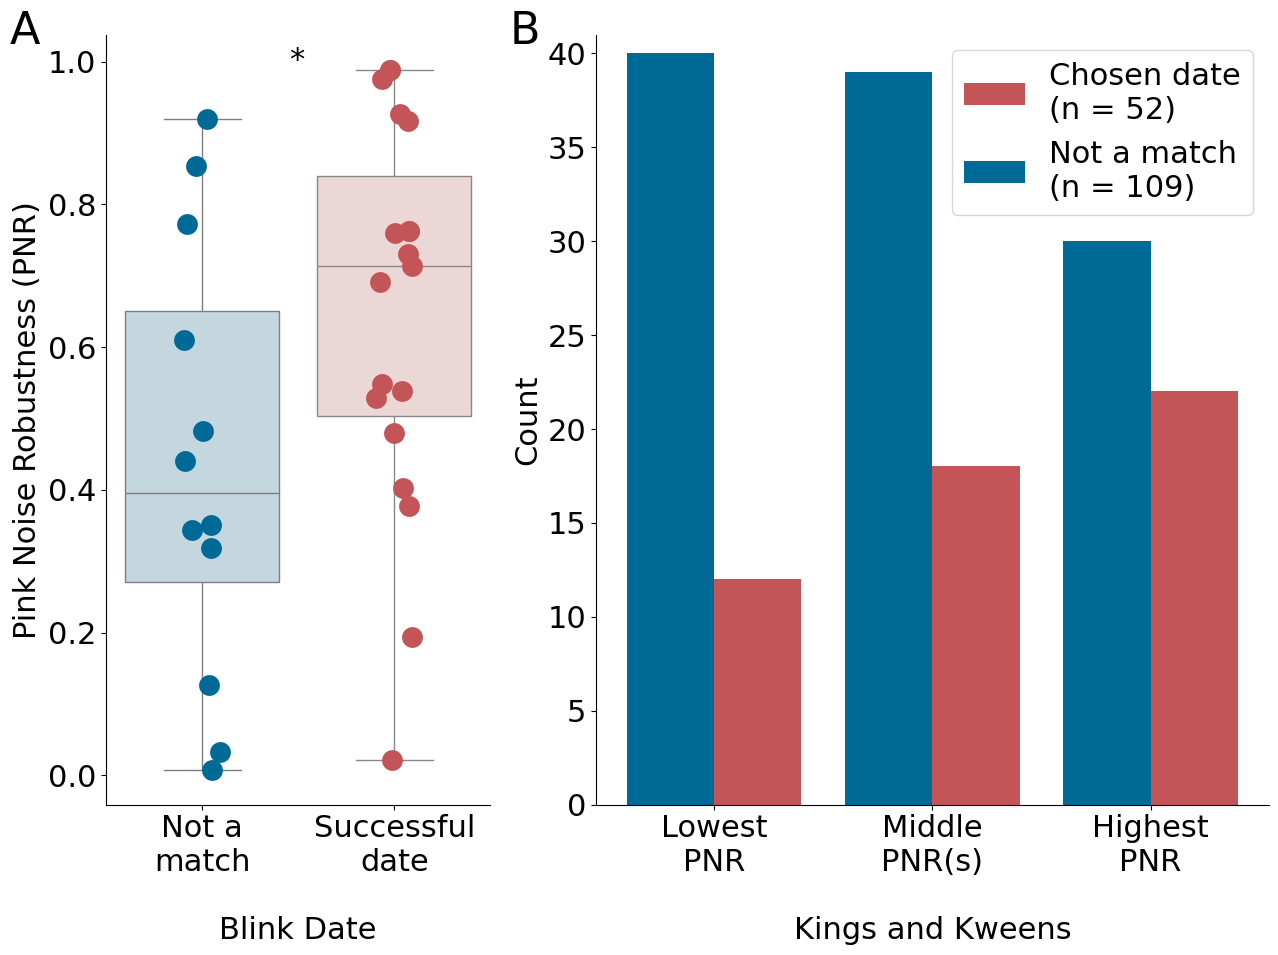

In [38]:
#@title Figure 4: Relationship between pink noise robustness and partner choice in real-world speed dates.

#Palette & make plot
main_pink = "#c35457"
main_blue = "#006a97"
main_pink_washed = "#efd4d4ff"
main_blue_washed = "#bfd9e4ff"

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, width_ratios = [1,1.75], figsize=(15, 10))

#Blink Date plot
sns.boxplot(x=0, y=blink_date_misses, color=main_blue_washed, ax=ax1)
sns.boxplot(x=1, y=blink_date_matches, color=main_pink_washed, ax=ax1)
sns.stripplot(x=0, y=blink_date_misses, color=main_blue, s=15, ax=ax1)
sns.stripplot(x=1, y=blink_date_matches, color=main_pink, s=15, ax=ax1)

ax1.set_xticks([0,1], ['Not a\nmatch', 'Successful\ndate'])
ax1.set_ylabel('Pink Noise Robustness (PNR)')
ax1.text(x=0.45, y =.99, s='*')
ax1.set_xlabel('\nBlink Date')

#Kings and Kweens plot
loser_heights = [Counter(kings_kweens_misses)[x] for x in [0,1,2]]
winner_heights = [Counter(kings_kweens_matches)[x] for x in [0,1,2]]
w=0.4
ax2.bar([0+w,1+w,2+w], winner_heights, width = w, color=main_pink)
ax2.bar([0,1,2], loser_heights, width = w, color=main_blue)
ax2.set_ylabel('Count')
ax2.legend(['Chosen date\n(n = {w})'.format(w=len(kings_kweens_matches)), 'Not a match\n(n = {l})'.format(l=len(kings_kweens_misses))])
ax2.set_xticks([0+w/2,1+w/2,2+w/2], ['Lowest\nPNR', 'Middle\nPNR(s)', 'Highest\nPNR']);
ax2.set_xlabel('\nKings and Kweens');
ax2.set_ylim(0,41)

ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)

ax1.text(x=-1, y=1.025, s='A', fontsize=32)
ax1.text(x=1.6, y=1.025, s='B', fontsize=32);

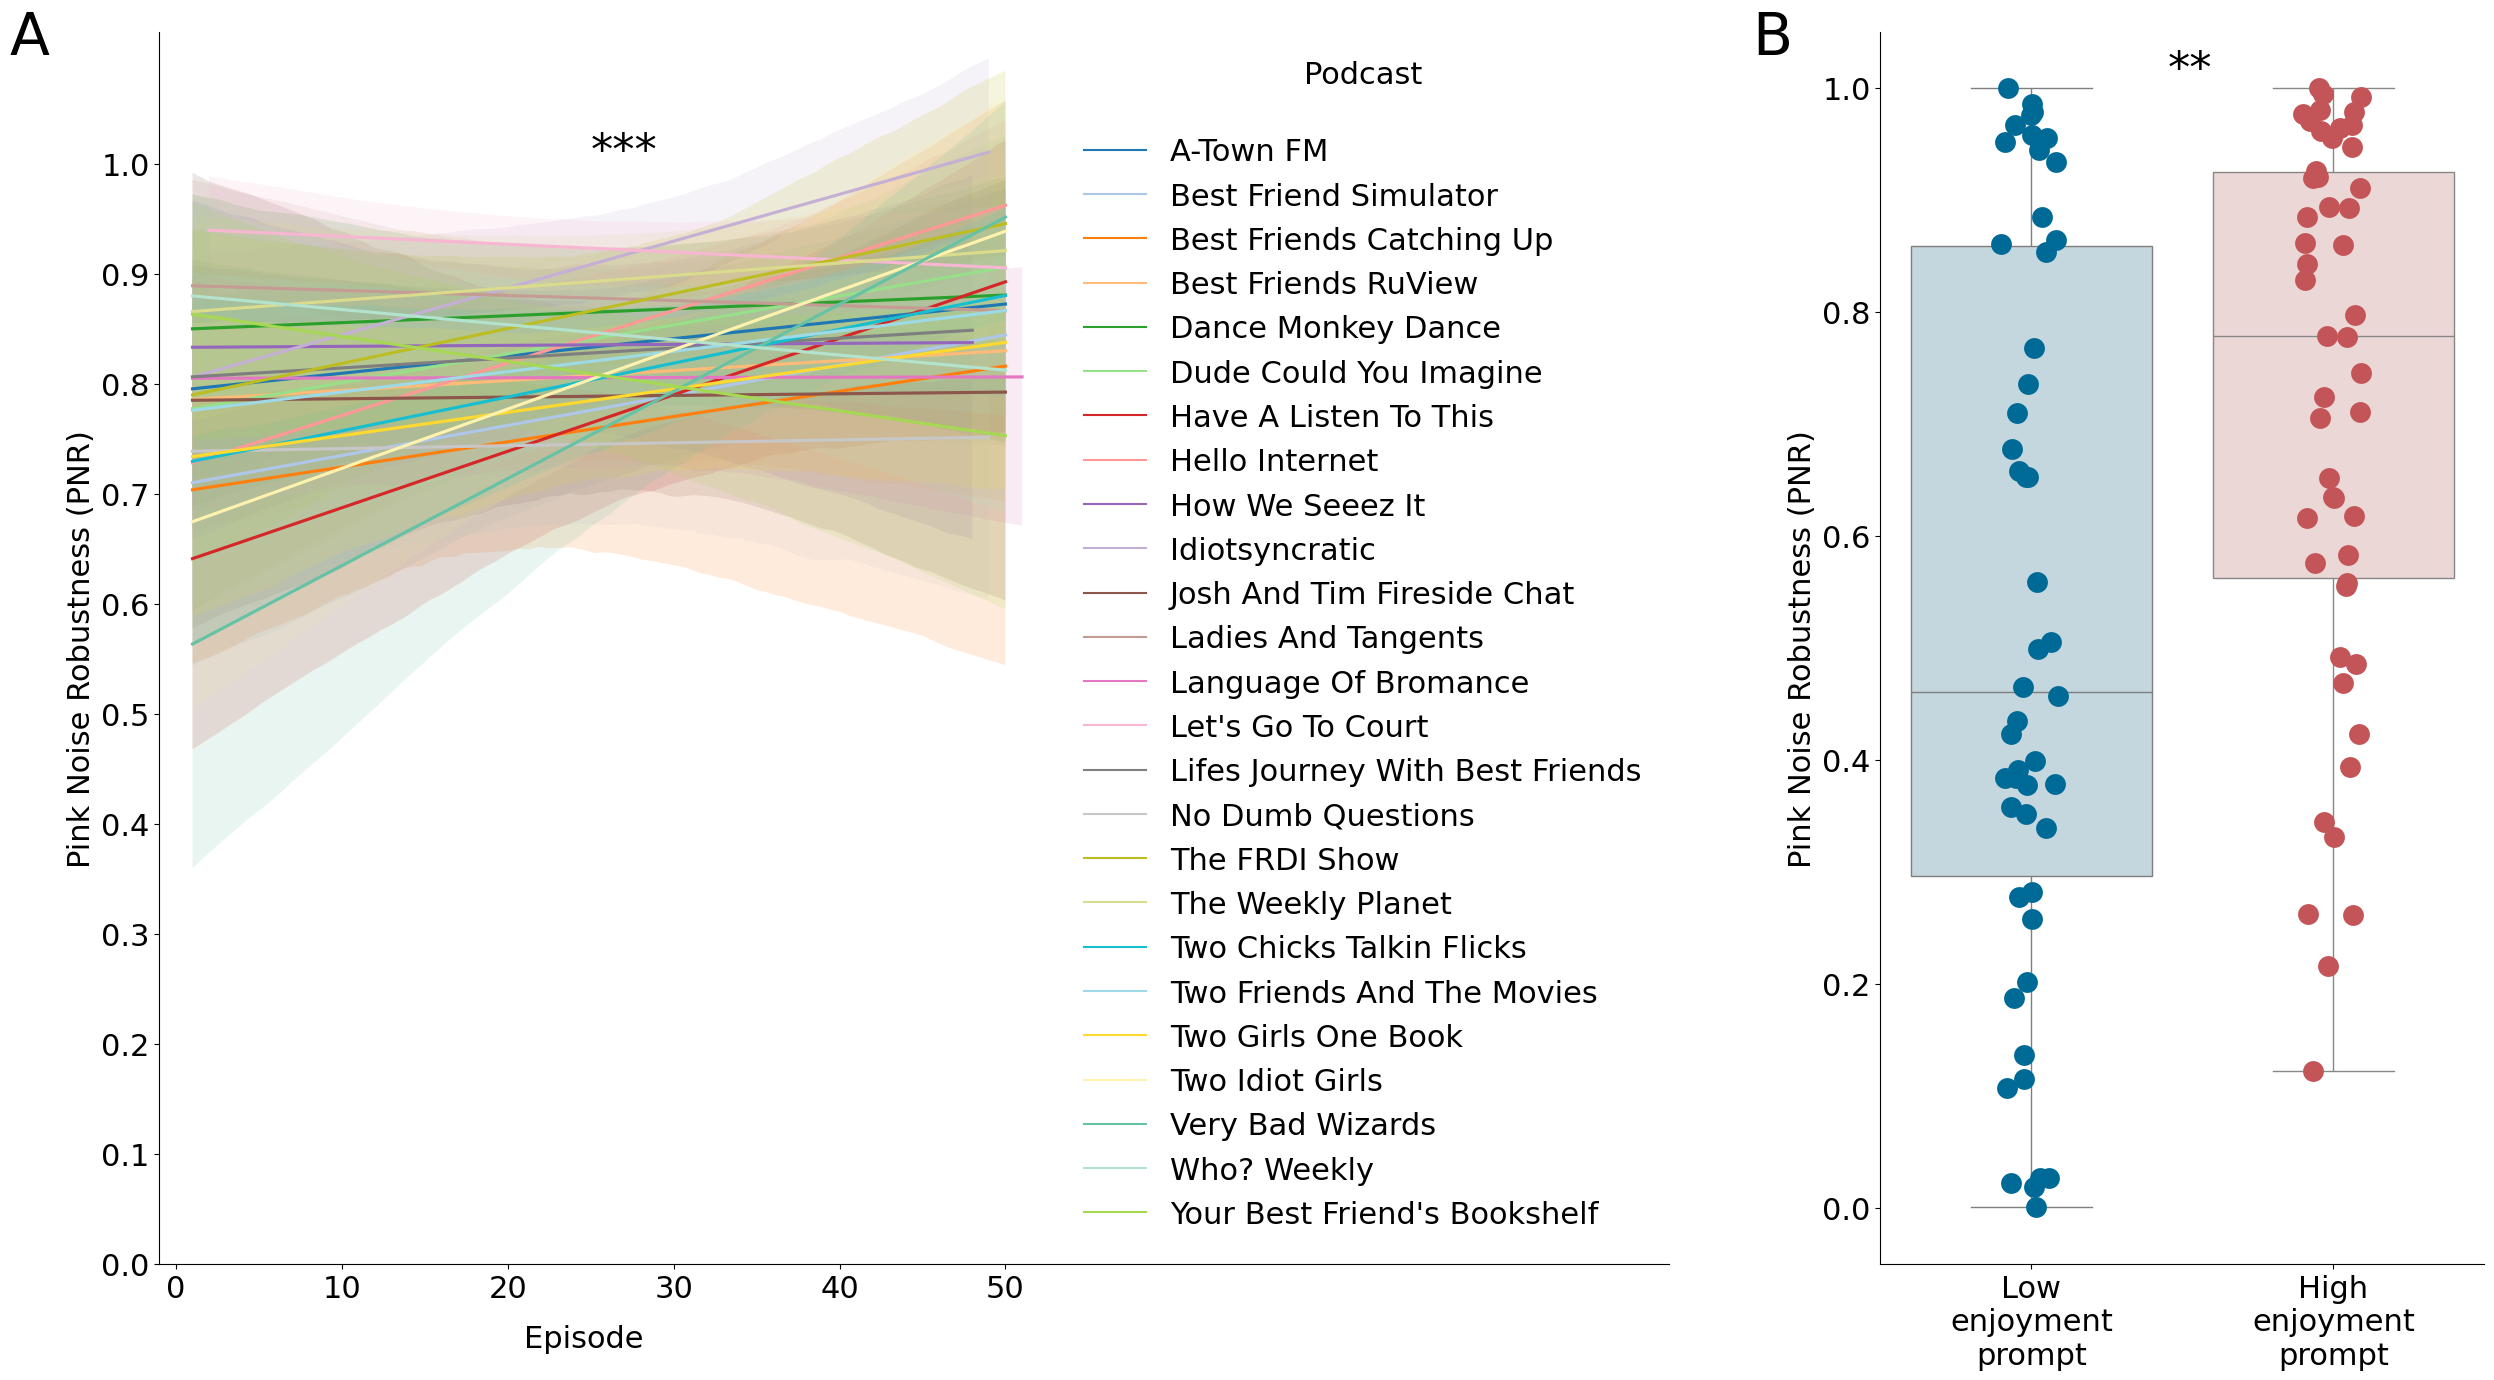

In [39]:
#@title Figure 5: Evidence of pink noise as a hallmark of optimal interpersonal semantic coordination from repeated conversations and large language model representations

#Palettes & make plot
tab20 = matplotlib.colormaps.get_cmap('tab20')
set2 = matplotlib.colormaps.get_cmap('Set2')
pastel2 = matplotlib.colormaps.get_cmap('Pastel2')
colors  = [tab20(i) for i in range(20)] + [set2(5), pastel2(5), set2(0), pastel2(0), set2(4)]
sns.set_palette(colors)

main_pink = "#c35457"
main_blue = "#006a97"
main_pink_washed = "#efd4d4ff"
main_blue_washed = "#bfd9e4ff"

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, width_ratios = [2.5, 1], figsize=(30, 16))

#PODCAST PLOT

#make legend
podcast_names = sorted(list(set(podcasts['Podcast'])))
for i in range(len(podcast_names)):
  ax1.plot([-10,-5], [-10,-5], color=colors[i])
ax1.legend(podcast_names, title='Podcast\n', frameon=False)

#line plots
for podcast_name in podcast_names:
  sns.regplot(podcasts[podcasts['Podcast']==podcast_name], x='Episode', y='pnr', ax=ax1, scatter=False)
ax1.set_ylabel('Pink Noise Robustness (PNR)')
ax1.set_xlabel('')
ax1.text(x=25, y=1.0, s='***', fontsize=32);
ax1.set_ylim(0.0,1.12)
ax1.set_xlim(-1,90)
ax1.set_xticks([0,10,20,30,40,50])
ax1.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax1.spines[['right', 'top']].set_visible(False)
ax1.text(21, -0.075, 'Episode')

#CLAUDE PLOT

sns.boxplot(x=0, y=bad_convo_pnrs, color=main_blue_washed, ax=ax2)
sns.boxplot(x=1, y=good_convo_pnrs, color=main_pink_washed, ax=ax2)
sns.stripplot(x=0, y=bad_convo_pnrs, color=main_blue, s=15, ax=ax2)
sns.stripplot(x=1, y=good_convo_pnrs, color=main_pink, s=15, ax=ax2)

ax2.set_xticks([0,1], ['Low\nenjoyment\nprompt', 'High\nenjoyment\nprompt'])
ax2.set_ylabel('Pink Noise Robustness (PNR)')

ax2.text(x=0.45, y =1.005, s='**', fontsize=32)
ax2.set_ylim(-0.05,1.05)
ax2.spines[['right', 'top']].set_visible(False)

ax1.text(x=-10, y=1.1, s='A', fontsize=42)
ax1.text(x=95, y=1.1, s='B', fontsize=42);


# Statistics

In [ ]:
#@title Load RPy for the mixed effects models
%load_ext rpy2.ipython

In [ ]:
#@title Install R packages
%%capture
%%R
install.packages("lme4")
install.packages("lmerTest")
library(lme4)
library(lmerTest)

In [ ]:
#@title Load the R packages properly
import rpy2.robjects.numpy2ri
import rpy2.robjects.pandas2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
rpy2.robjects.pandas2ri.activate()
stats = importr('stats')
lme4 = importr('lme4')
lmerTest = importr('lmerTest')

In [35]:
#@title Enjoyment and connection variables are over-represented in the sets of variables whose correlations with PNR survive multiple hypothesis correction
passed_bonferroni = candorCorrelations[candorCorrelations['passes_Bonferroni']]['category']
did_not_pass_bonferroni = candorCorrelations[~candorCorrelations['passes_Bonferroni']]['category']

passed_fdr = candorCorrelations[candorCorrelations['passes_FDR']]['category']
did_not_pass_fdr = candorCorrelations[~candorCorrelations['passes_FDR']]['category']

categories = [ 'Enjoyment', 'Connection', 'Engagement/memory', 'Own traits', 'Other traits', 'Demographics/low-level','Other']
contingency_bonferroni = np.array([[Counter(passed_bonferroni)[category] for category in categories], [Counter(did_not_pass_bonferroni)[category] for category in categories]])
contingency_fdr = np.array([[Counter(passed_fdr)[category] for category in categories], [Counter(did_not_pass_fdr)[category] for category in categories]])

print('Bonferroni version')
print(stats.fisher_test(contingency_bonferroni))
print('FDR version')
print(stats.fisher_test(contingency_fdr, simulate_p_value=True))


Bonferroni version

	Fisher's Exact Test for Count Data

data:  structure(c(5L, 20L, 2L, 14L, 0L, 20L, 0L, 55L, 0L, 41L, 0L, 43L, 0L, 5L), dim = c(2L, 7L))
p-value = 0.000154
alternative hypothesis: two.sided


FDR version

	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  structure(c(22L, 3L, 9L, 7L, 4L, 16L, 4L, 51L, 5L, 36L, 2L, 41L, 0L, 5L), dim = c(2L, 7L))
p-value = 0.0004998
alternative hypothesis: two.sided




In [34]:
#@title First PCs for enjoyment and connection are correlated with PNR, but not one's own traits
convoIDs = sorted(list(set(candorPCs.keys())))
enjoyment = [candorPCs[convoID]['survey_pca']['Enjoyment_PC1'] for convoID in convoIDs]
connection = [candorPCs[convoID]['survey_pca']['Connection_PC1'] for convoID in convoIDs]
own_traits = [candorPCs[convoID]['survey_pca']['Own traits_PC1'] for convoID in convoIDs]
pnrs = [candorPCs[convoID]['pnr'] for convoID in convoIDs]

r,p = pearsonr(enjoyment, pnrs)
print('Enjoyment x PNR:\nR = {r:.02f}  p = {p:.04f}'.format(r=r,p=p))
r,p = pearsonr(connection, pnrs)
print('\nConnection x PNR:\nR = {r:.02f}  p = {p:.04f}'.format(r=r,p=p))
r,p = pearsonr(own_traits, pnrs)
print('\nOwn traits x PNR:\nR = {r:.02f}  p = {p:.04f}'.format(r=r,p=p))

Enjoyment x PNR:
R = 0.09  p = 0.0004

Connection x PNR:
R = 0.07  p = 0.0032

Own traits x PNR:
R = 0.03  p = 0.2296


In [33]:
#@title The PNRs of individual speakers' trajectories through semantic space do not account for the same variance in enjoyment/connection as the whole-conversation PNRs
%%R
data <- read.csv("individualData.csv")

cat('\nENJOYMENT\n')
model <- lm(enjoyment ~ whole_convo_pnr + speaker_pnr + partner_pnr, data=data)
print(summary(model))

cat('\nCONNECTION\n')
model <- lm(connection ~ whole_convo_pnr + speaker_pnr + partner_pnr, data=data)
print(summary(model))


ENJOYMENT

Call:
lm(formula = enjoyment ~ whole_convo_pnr + speaker_pnr + partner_pnr, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-16.836  -1.925   0.213   2.354   8.122 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.5600     0.2748  -5.676 1.49e-08 ***
whole_convo_pnr   0.9555     0.2606   3.666 0.000250 ***
speaker_pnr       0.4359     0.2025   2.152 0.031433 *  
partner_pnr       0.7789     0.2025   3.846 0.000122 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.305 on 3306 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.01073,	Adjusted R-squared:  0.009832 
F-statistic: 11.95 on 3 and 3306 DF,  p-value: 8.791e-08


CONNECTION

Call:
lm(formula = connection ~ whole_convo_pnr + speaker_pnr + partner_pnr, 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5390  -1.4550   0.3279   1.8233   6.548

In [32]:
#@title Individual speakers did not have PNR scores across conversations that were identifying (i.e. PNR is not the direct result of individual conversation skill or tendencies)
rows = []
for convo_id in candorPCs.keys():
  pnr = candorPCs[convo_id]['pnr']
  speakerA, speakerB = candorPCs[convo_id]['individual_values'].keys()
  rows.append([speakerA, pnr])
  rows.append([speakerB, pnr])

df = pd.DataFrame(rows, columns=['speaker', 'PNR']).dropna()
df = df[[Counter(df['speaker'])[speaker] >= 5 for speaker in df['speaker']]].sort_values('speaker').reset_index(drop=True)

speaker_ids = list(df['speaker'])
speaker_distance_matrix = np.ones((len(speaker_ids), len(speaker_ids)))
for a in range(len(speaker_ids)):
  for b in range(a, len(speaker_ids)):
    if speaker_ids[a] == speaker_ids[b]:
      speaker_distance_matrix[a][b] = 0
      speaker_distance_matrix[b][a] = 0

#pnr_distance_matrix = pairwise_distances(np.array(df['PNR']).reshape(-1,1))
pnr_distance_matrix = squareform(pdist(np.array(df['PNR']).reshape(-1,1)))

corr, pval, z = mantel.test(speaker_distance_matrix, pnr_distance_matrix)
print("Correlation between identity and PNR distances: {:.3f}".format(corr))
print("P value: {:.3f}".format(pval))
print("Z score: {:.3f}".format(z))

Correlation between identity and PNR distances: 0.001
P value: 0.123
Z score: 1.532


In [31]:
#@title Adding average similarity, simialrity variance, and similarity slope to a multiple regression model predicting conversation enjoyment/connection does not remove PNR as a significant predictor (i.e. linear metrics do not account for all of the variance explained by non-linear interactions)
%%R
data <- read.csv("linearAlternatives.csv")
data$pnr <- scale(data$pnr)
data$similarity_slope <- scale(data$similarity_slope)
data$average_similarity <- scale(data$average_similarity)
data$similarity_variance <- scale(data$similarity_variance)

cat('\nENJOYMENT\n')
model <- lm(enjoyment ~ pnr + similarity_slope + average_similarity + similarity_variance, data=data)
print(summary(model))

cat('\nCONNECTION\n')
model <- lm(connection ~ pnr + similarity_slope + average_similarity + similarity_variance, data=data)
print(summary(model))


ENJOYMENT

Call:
lm(formula = enjoyment ~ pnr + similarity_slope + average_similarity + 
    similarity_variance, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.8445  -2.0344   0.2221   2.2819  10.0522 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -1.018e-16  8.339e-02   0.000  1.00000    
pnr                  2.509e-01  8.475e-02   2.961  0.00311 ** 
similarity_slope     2.190e-01  8.494e-02   2.579  0.01000 *  
average_similarity  -1.293e-01  1.250e-01  -1.034  0.30126    
similarity_variance -5.051e-01  1.234e-01  -4.093 4.46e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.393 on 1651 degrees of freedom
Multiple R-squared:  0.04218,	Adjusted R-squared:  0.03986 
F-statistic: 18.18 on 4 and 1651 DF,  p-value: 1.268e-14


CONNECTION

Call:
lm(formula = connection ~ pnr + similarity_slope + average_similarity + 
    similarity_variance, data = data)



In [30]:
#@title Conversation PNR predicts the first PC of enjoyment- and connection-related variables in a second dataset (Interracial Friends)
convoIDs = sorted(list(set(interracialPCs.keys())))
enjoyment = [interracialPCs[convoID]['Enjoyment_PC1'] for convoID in convoIDs]
connection = [interracialPCs[convoID]['Connection_PC1'] for convoID in convoIDs]
own_traits = [interracialPCs[convoID]['Own traits_PC1'] for convoID in convoIDs]
pnrs = [interracialPCs[convoID]['pnr'] for convoID in convoIDs]

r,p = pearsonr(enjoyment, pnrs)
print('Enjoyment x PNR:\nR = {r:.02f}  p = {p:.04f}'.format(r=r,p=p))
r,p = pearsonr(connection, pnrs)
print('\nConnection x PNR:\nR = {r:.02f}  p = {p:.04f}'.format(r=r,p=p))
r,p = pearsonr(own_traits, pnrs)
print('\nOwn traits x PNR:\nR = {r:.02f}  p = {p:.04f}'.format(r=r,p=p))

Enjoyment x PNR:
R = 0.30  p = 0.0035

Connection x PNR:
R = 0.29  p = 0.0053

Own traits x PNR:
R = 0.09  p = 0.3762


In [29]:
#@title Successful dates in the Blink Date corpus had higher PNRs than those that did not result in matches
t,p = ttest_ind(blink_date_matches, blink_date_misses, alternative="greater")
print('T-stat = {t:.3f}\tp = {p:.03f}'.format(t=t,p=p))

T-stat = 1.990	p = 0.028


In [28]:
#@title In the Kings and Kweens corpus, the ranking of a conversation’s PNR (highest, lowest, or middle of that episode) significantly predicted whether that conversation resulted in a second date
%%R
data <- read.csv("kings-kweens.csv")
model <- glm(winner ~ pnr_order, family='binomial', data=data)
print(summary(model))


Call:
glm(formula = winner ~ pnr_order, family = "binomial", data = data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.2108     0.2926  -4.138  3.5e-05 ***
pnr_order     0.4478     0.2155   2.078   0.0377 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 202.57  on 160  degrees of freedom
Residual deviance: 198.13  on 159  degrees of freedom
AIC: 202.13

Number of Fisher Scoring iterations: 4



In [27]:
#@title Pairs that engage in regular conversations over the course of several weeks demonstrate stronger pink noise signals over time
%%R
data <- read.csv("podcasts.csv")
model <- lmer(pnr ~ episode +(1|Podcast), data=data)
print(summary(model))


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: pnr ~ episode + (1 | Podcast)
   Data: data

REML criterion at convergence: -218.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7883 -0.4006  0.3896  0.6825  1.1086 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Podcast  (Intercept) 0.0009243 0.0304  
 Residual             0.0458093 0.2140  
Number of obs: 1030, groups:  Podcast, 25

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 7.792e-01  1.455e-02 1.453e+02  53.539  < 2e-16 ***
episode     1.794e-03  4.562e-04 1.012e+03   3.933 8.97e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
episode -0.782


In [26]:
#@title An LLM is capable of generating "good" and "bad" conversations in which good conversations have higher average enjoyment scores from human raters than bad conversations
good_enjoyment = claude_ratings[claude_ratings['condition']=='good']['enjoyment']
bad_enjoyment = claude_ratings[claude_ratings['condition']=='bad']['enjoyment']
t,p = ttest_ind(good_enjoyment, bad_enjoyment)

print('Good convo mean: {:.2f}'.format(np.mean(good_enjoyment)))
print('Good convo std: {:.2f}'.format(np.std(good_enjoyment)))
print('Bad convo mean:  {:.2f}'.format(np.mean(bad_enjoyment)))
print('Bad convo std: {:.2f}'.format(np.std(bad_enjoyment)))

print('\nT-stat = {t:.3f}\tp = {p:.03f}'.format(t=t,p=p))

Good convo mean: 4.83
Good convo std: 0.17
Bad convo mean:  2.44
Bad convo std: 0.59

T-stat = 27.104	p = 0.000


In [25]:
#@title And, these good conversations have higher PNR values

good_pnrs = claude[claude['condition']=='good']['pnr']
bad_pnrs = claude[claude['condition']=='bad']['pnr']
t,p = ttest_ind(good_pnrs, bad_pnrs)

print('Good convo mean: {:.2f}'.format(np.mean(good_pnrs)))
print('Bad convo mean:  {:.2f}'.format(np.mean(bad_pnrs)))
print('\nT-stat = {t:.3f}\tp = {p:.03f}'.format(t=t,p=p))

Good convo mean: 0.72
Bad convo mean:  0.53

T-stat = 3.354	p = 0.001
